In [1]:
import sys
import os
!{sys.executable} -m pip install ipykernel==6.0
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath('')), '..'))

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
pd.options.mode.chained_assignment = None

In [2]:
def transform_file(file : str, newfile : str, attacks : list):
     attack_dicts = { attack : { "Precision" : {}, "Recall" : {}, "AUROC" : {}, "AUPR" : {}, "FPR@95%TPR" : {}, "FPR" : {}, "TP_MMPS" : {}, "FP_MMPS" : {}, "FN_MMPS" : {}, "TN_MMPS" : {}} for attack in attacks}

     with open('../results/'+file+".json", 'r') as j:
          contents = json.loads(j.read())
          for i,c in enumerate(contents[0]): 
               dataset = c.split("_")[-1]
               value = format(contents[0][c],'.4f')
               for attack in attacks:
                    if attack in c:
                         if "precision" in c:
                              attack_dicts[attack]["Precision"][dataset] = value
                         elif "recall" in c:
                              attack_dicts[attack]["Recall"][dataset] = value
                         elif "auroc" in c:
                              attack_dicts[attack]["AUROC"][dataset] = value
                         elif "aupr" in c:
                              attack_dicts[attack]["AUPR"][dataset] = value
                         elif "auroc" in c:
                              attack_dicts[attack]["AUROC"][dataset] = value
                         elif "fpr_at_tpr95" in c:
                              attack_dicts[attack]["FPR@95%TPR"][dataset] = value
                         elif "tp_mmps" in c:
                              attack_dicts[attack]["TP_MMPS"][dataset] = value
                         elif "fp_mmps" in c:
                              attack_dicts[attack]["FP_MMPS"][dataset] = value
                         elif "fn_mmps" in c:
                              attack_dicts[attack]["FN_MMPS"][dataset] = value
                         elif "tn_mmps" in c:
                              attack_dicts[attack]["TN_MMPS"][dataset] = value
                         elif "fpr" in c:
                              attack_dicts[attack]["FPR"][dataset] = value
     dfs = []
     for attack in attacks:
          dfs.append(pd.DataFrame.from_dict(attack_dicts[attack]))
          dfs[-1].rename(columns=lambda x: attack + " " + x, inplace=True)
     df = pd.concat(dfs,axis=1)
     df.to_csv("../results/"+ newfile + "_attack_results.csv", encoding='utf-8')

In [3]:
def get_cleaned_dataframe(csv_file_path, attacks, attackNames, metric, rows_to_keep=None):
    
    # read the csv file
    df = pd.read_csv(csv_file_path)
    relevant = ['Unnamed: 0'] + [a+" "+metric for a in attacks]
    
    # get only the relevant columns
    df = df.loc[:,df.columns.isin(relevant)]
    df = df.loc[:, ~df.where(df.astype(bool)).isna().all(axis=0)]
    
    df.rename(columns=dict({'Unnamed: 0': 'Dataset'},**{a+" "+metric:attackNames[i] for (i,a) in enumerate(attacks)}), inplace=True)
    df.index = df['Dataset'].values.tolist()

    if rows_to_keep is not None:
        df = df[df['Dataset'].isin(rows_to_keep)]
        df = df.reindex(rows_to_keep)
    
    df_ls = None
    df_llla = None
    try:
        file_ls = csv_file_path.replace("_attack","_LS_attack")
        df_ls = pd.read_csv(file_ls)
        df_ls = df_ls.loc[:,df_ls.columns.isin(relevant)]
        df_ls = df_ls.loc[:, ~df_ls.where(df_ls.astype(bool)).isna().all(axis=0)]
        names_ls = dict({'Unnamed: 0': 'Dataset'},**{a+" "+metric:attackNames[i]+" with LS" for (i,a) in enumerate(attacks)})
        df_ls.rename(columns=names_ls, inplace=True)
        df_ls.index = df_ls['Dataset'].values.tolist()
        df_ls = df_ls.sort_values('Dataset',ascending=False)

        if rows_to_keep is not None:
            df_ls = df_ls[df_ls['Dataset'].isin(rows_to_keep)]
            df_ls = df_ls.reindex(rows_to_keep)
    except Exception as e:
        pass
    try:
        file_llla = csv_file_path.replace("_attack","_LLLA_attack")
        df_llla = pd.read_csv(file_llla)
        df_llla = df_llla.loc[:,df_llla.columns.isin(relevant)]
        df_llla = df_llla.loc[:, ~df_llla.where(df_llla.astype(bool)).isna().all(axis=0)]
        df_llla.rename(columns={'Unnamed: 0': 'Dataset'}+{a+' with LLLA' for a in attackNames}, inplace=True)
        df_llla.index = df_llla['Dataset'].values.tolist()
        df_llla = df_llla.sort_values('Dataset',ascending=False)
        if rows_to_keep is not None:
            df_llla = df_llla[df_llla['Dataset'].isin(rows_to_keep)]
            df_llla = df_llla.reindex(rows_to_keep)
    except Exception as e:
        pass

    return df, df_ls, df_llla

def plot_dataframe(model, metric, df1, df2,textsize,figsize=(20, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.tick_params(axis='y', labelsize=textsize)
    ax.yaxis.label.set_size(textsize)
    ax.yaxis.label.set_weight('bold')
    for tick_label in ax.get_xticklabels():
        tick_label.set_fontweight('bold')

    for tick_label in ax.get_yticklabels():
        tick_label.set_fontweight('bold')
 
    ax.grid(True)
    ax = sns.barplot(x="Dataset",y=metric,hue="Attack",alpha=0.3,data=df1,palette="tab10")
    if df2 is not None:
        df2 = df2.set_index('Dataset')
        df2 = df2.loc[list(df.Dataset)]
        ax = sns.barplot(x=df2.index,y=metric,hue="Attack",alpha=1,data=df2,palette="tab10",ci=None)

    xticklabels = [a.get_text() for a in ax.get_xticklabels()]
    ax.set_xticklabels(xticklabels, rotation=50, size=textsize, ha='right')
    ax.set_ylim([0,1])
    ax.set(xlabel="")

    handles, labels = ax.get_legend_handles_labels()
    handles = handles[3:]
    labels = [l[:-8] for l in labels[3:]]
    ax.legend(handles=handles, labels=labels, loc="best", prop={'weight':'bold', 'size':textsize}, frameon=True, labelspacing=0.05, borderpad=0.2, borderaxespad=0.0, framealpha=1, handletextpad=0.2)
    #plt.legend("")
    return ax

In [4]:
attacks_all = ["AugmentationAttack","RandomNoiseAttack","DecisionBoundaryAttack","EntropyAttack","ThresholdAttack","SalemAttack"]
attacks = ["AugmentationAttack","RandomNoiseAttack","DecisionBoundaryAttack","EntropyAttack","ThresholdAttack","SalemAttack"]
attackNames = ["Data Augmentation","Noise Robustness","Decision Boundary","Entropy","Threshold","Salem"]
transform_file("resnet_test","resnet_test",attacks_all)
transform_file("resnet18","resnet18",attacks)
transform_file("resnet18_LS","resnet18_LS",attacks)
transform_file("resnet50","resnet50",attacks)
transform_file("resnet50","resnet50_LS",attacks)
transform_file("salem","salem",attacks)
transform_file("salem_LS","salem_LS",attacks)
transform_file("efficient","efficient",attacks)
transform_file("efficient","efficient_LS",attacks)

resnet18
salem
efficient
resnet50


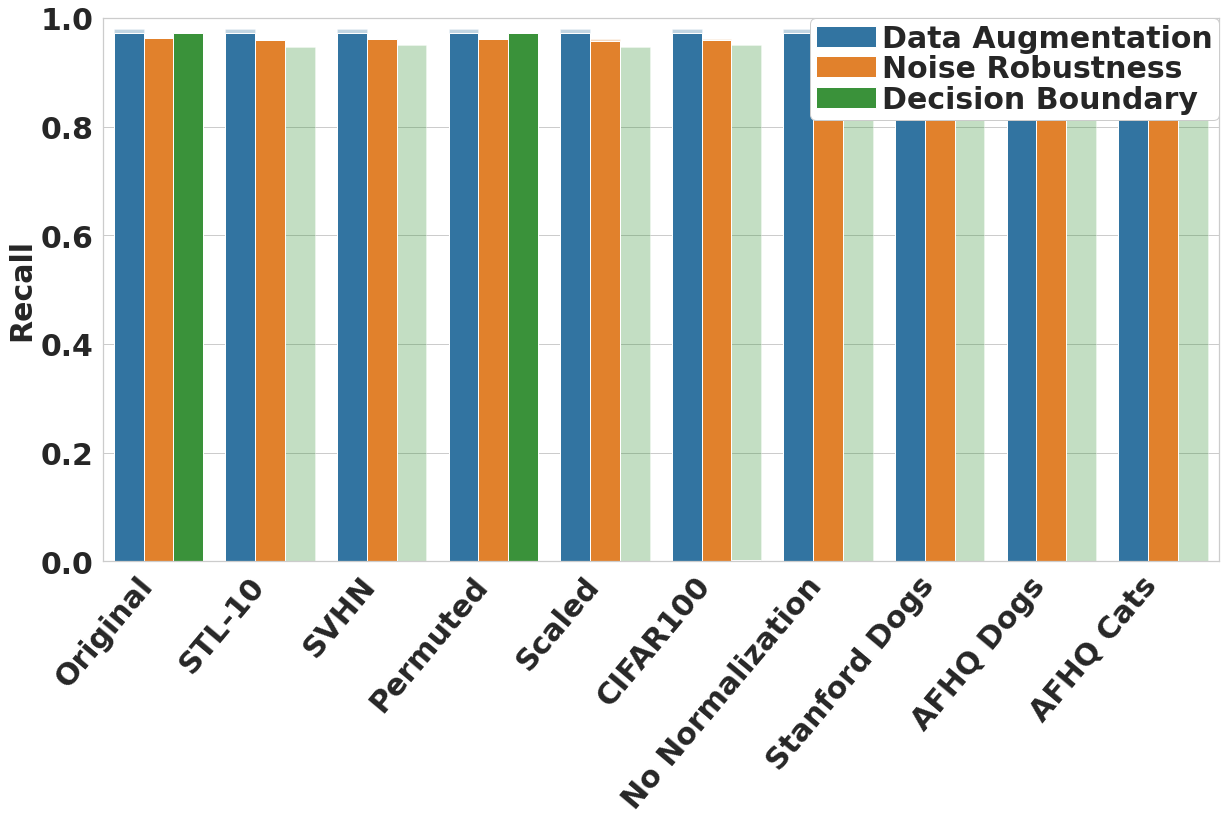

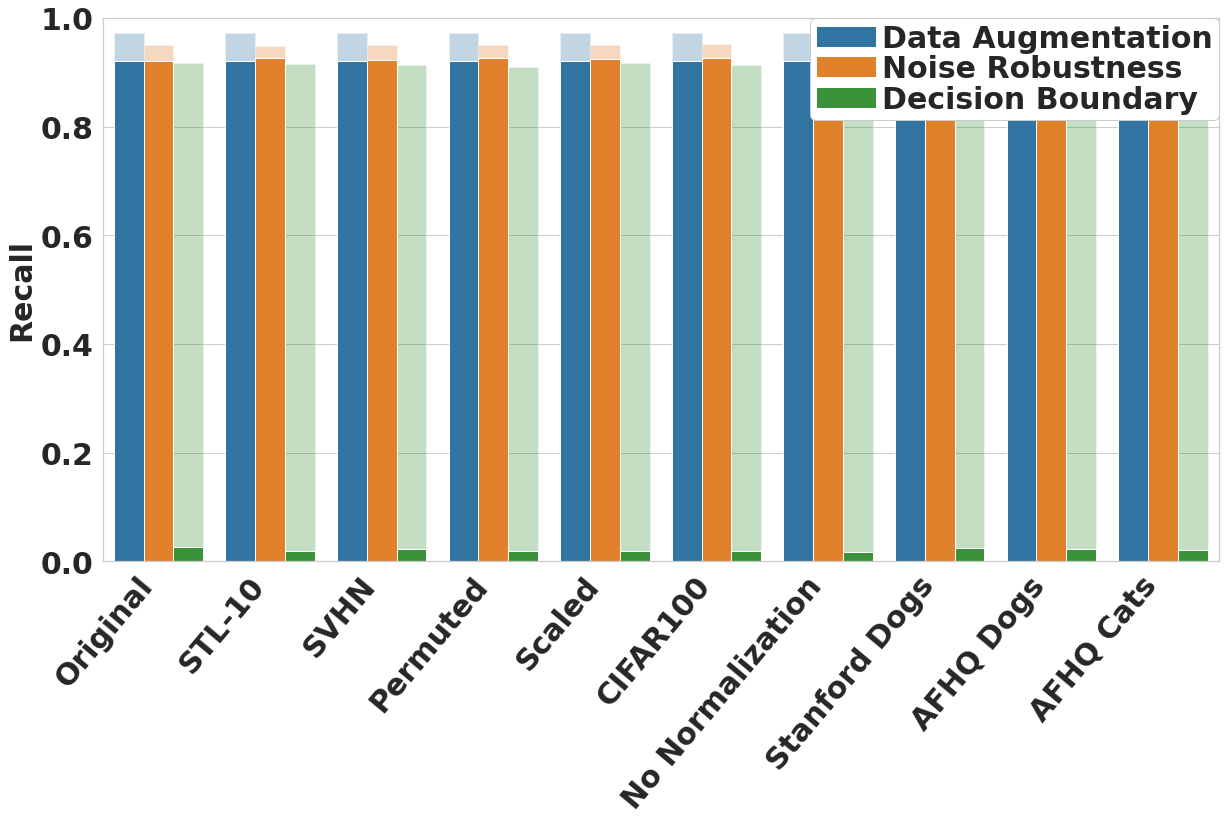

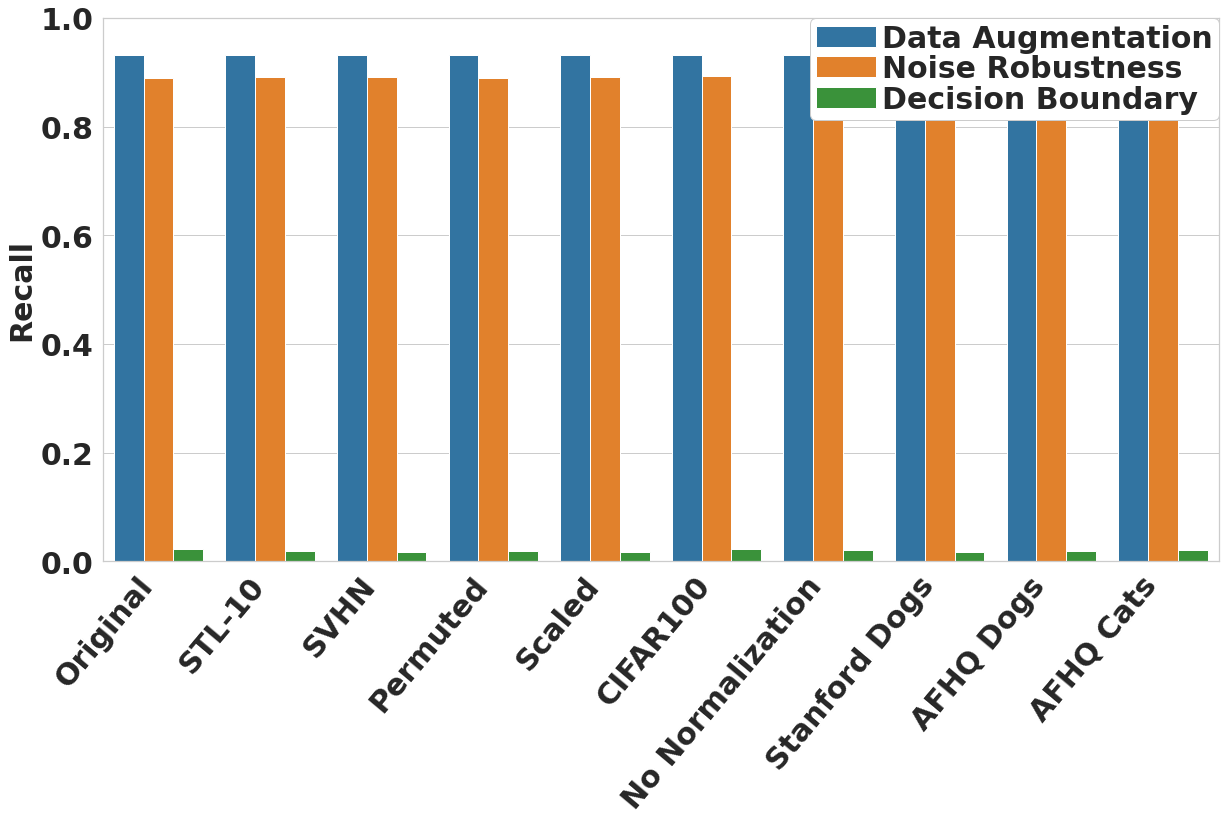

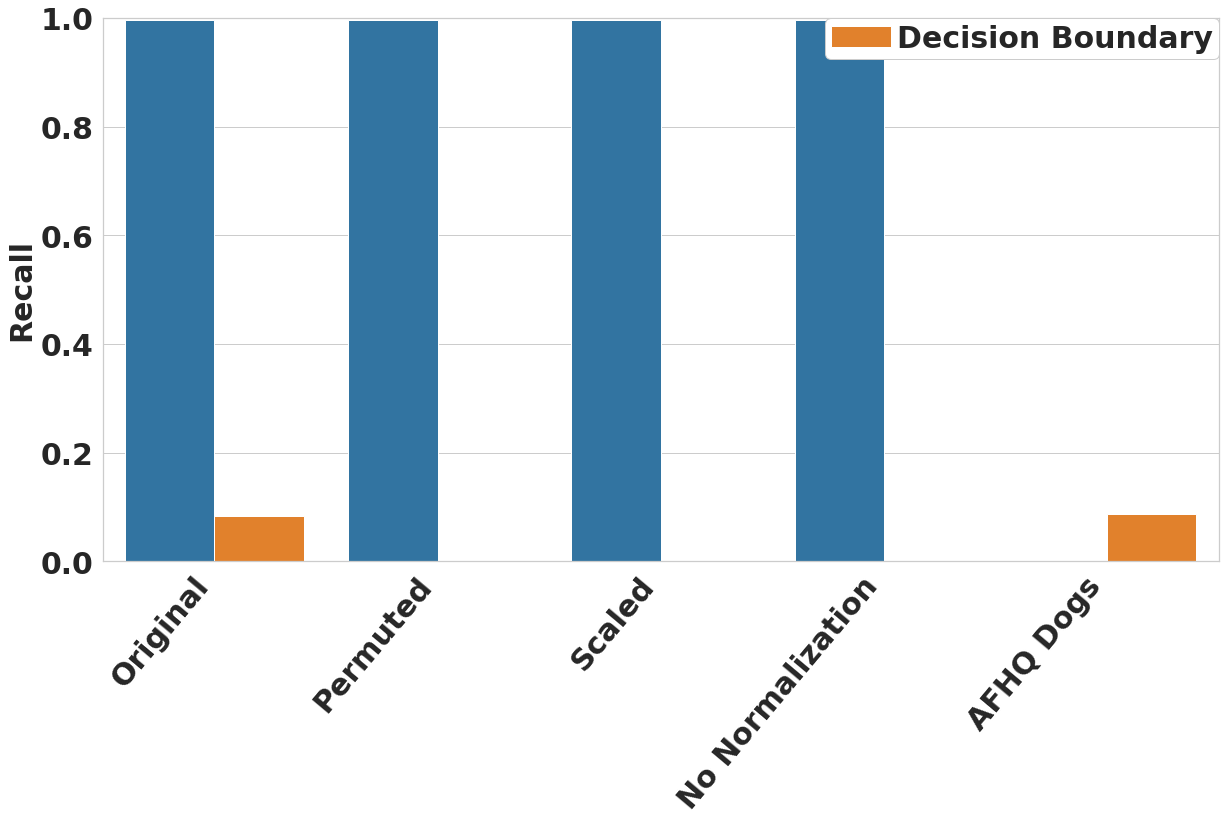

In [5]:
rows_to_keep = ["Original","Fake CiIFAR-10","STL-10","SVHN","Permuted","Scaled","CIFAR100","No Normalization","Stanford Dogs","AFHQ Dogs","AFHQ Cats"]
models = ["resnet18","salem","efficient","resnet50"]
metric = "Recall"

for model in models:
    print(model)
    df, df_ls, df_llla = get_cleaned_dataframe('../results/'+model+'_attack_results.csv', attacks_all, attackNames, metric,rows_to_keep)
    df = pd.melt(df, id_vars=['Dataset'], var_name='Attack', value_name=metric)
    if df_ls is not None:
        df_ls = pd.melt(df_ls, id_vars=['Dataset'], var_name='Attack', value_name=metric)
    ax = plot_dataframe(model, metric, df, df_ls,30)
    fig = ax.get_figure()
    fig.savefig(model+'_attack_results_scores.pdf')